##### Machine Learning

- Suppression des variables non utiles pour la prédiction</br>
- Encodage des variables catégorielles
- Normalisation des attributs numériques (Voir Pipeline )
- Imputation de valeurs manquantes
- Suppression des outliers
- etc

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

In [3]:
data=pd.read_csv("../datasets/dataset.csv",sep=';')

In [4]:
data.head()

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,compte_joint,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
0,3463,H,0.0,non,non,37.0,oui,consommation,medium,oui,non,non,non,oui,non,pro,oui,mail,91.15,3369.25,30.0,A4,3788.182745,5945.077267,10803.089959,13030.928518,16070.855640,17019.439852,22021.785596,21216.423900,23817.283384,24696.468636,NaN,29133.894497,27300.071162,26686.065056,29058.920542,30081.575645,34737.732143,35668.424115,42088.923198,42764.084114,1169.512733,1476.735096,2906.612116,4238.286461,6541.289876,5604.843020,8529.610222,6698.675290,8299.637103,8584.519863,8285.480439,13545.535937,12243.785415,12140.590245,9013.777747,11604.261036,16390.415593,14631.204899,23988.305931,NORD-OUEST,non
1,1869,H,0.0,oui,oui,72.0,oui,consommation,premium,inconnu,inconnu,inconnu,inconnu,inconnu,inconnu,NaN,non,sms,24.10,1734.65,53.0,B1,13256.481090,13857.639282,16921.648902,15994.602590,19860.270780,21737.139931,24324.244241,27392.121666,29288.212735,31119.430165,32536.150958,33491.895175,36037.986828,37906.966495,37065.723883,36662.943135,35995.908243,38504.550415,39879.461696,40351.659648,4040.767255,2893.438448,4522.323311,3289.390612,8409.097755,5939.488953,6615.523133,8423.928612,9664.847859,12811.297554,13850.568156,14014.989673,15508.546834,17547.988381,15470.524076,17537.628474,17410.472648,21258.908987,21554.411100,NORD-OUEST,non
2,3760,H,0.0,non,non,3.0,oui,NaN,medium,non,non,oui,non,non,non,pro,oui,sms,73.60,232.5,41.0,B2,6485.760225,8854.292447,14631.403255,16403.253266,20053.910352,24404.311456,NaN,NaN,28995.145157,31381.332311,34524.328158,37696.137418,40010.389451,39991.336181,42066.099905,46159.092725,46548.328134,49017.799992,50879.800091,50811.414357,641.888116,2194.386006,4719.557270,5592.923372,6652.559765,11578.741807,10784.182742,10408.668590,11426.817452,11686.025962,16764.322564,17239.846026,19479.322456,21343.802381,24084.291026,25823.493343,25839.829752,25587.814976,29736.376226,NORD-OUEST,non
3,3820,H,1.0,oui,non,72.0,oui,consommation,medium,oui,oui,oui,oui,NaN,oui,pro,oui,sms,112.90,8061.5,44.0,C4,3023.518886,3657.280381,3583.864370,7048.335851,10851.522505,13233.449469,17043.445440,17315.324866,18409.009200,20992.136261,25680.971636,26021.839063,28987.451966,28467.733523,30863.437099,NaN,35443.442964,42466.157213,47617.669527,50441.094534,846.588009,300.647893,NaN,623.554669,1411.534141,2919.154899,4837.868424,6297.571985,4694.966744,8601.779273,6895.959437,9229.470887,11935.244779,11014.748509,11791.353542,16354.051367,15449.967495,21149.789933,29211.314803,NORD-OUEST,non
4,1463,F,0.0,non,non,4.0,oui,permanent,medium,non,non,non,non,non,non,pro,non,mail,70.40,281,32.0,B2,5108.994106,4922.134385,5619.387384,5967.906772,11720.904970,15561.132418,14934.624990,16295.563660,18983.711353,20997.917940,23264.257596,21750.759870,19947.127129,20916.130056,21685.913416,23620.334323,24778.901653,22870.646400,25475.278671,28725.910656,533.782193,977.257244,782.571668,1830.376484,2025.910611,2696.413807,2883.741954,4206.610511,4990.114457,7081.966623,8472.294920,9008.641700,5875.342745,6101.742525,8026.508871,10361.246523,10575.966610,6714.625315,9101.978017,NORD-OUEST,oui


###### preprocessing

TrainTest - Nettoyage - Encodage

In [5]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
def transformation(df):
    col=['interet_compte_epargne_total','espace_client_web']
    df[col[0]]=pd.to_numeric(df[col[0]],errors='coerce')
    df[col[1]]=df[col[1]].astype('object')
    return df

In [7]:
def encodage(df):
    cat_cols = []
    var_features = [feature for feature in df.columns if feature.startswith('var_')]
    other_features = [feature for feature in df.columns if feature not in var_features ]
    for column in other_features:
        if column not in ['id_client','anciennete_mois','agios_6mois','interet_compte_epargne_total','age','churn']:
            cat_cols.append(column)
    # Encodage one-hot 
    df= pd.get_dummies(df,columns=cat_cols,dummy_na=True)
    nan_df = df.loc[:, df.columns.str.endswith("_nan")] # extraire les variables se terminant par _nan
    # Cette partie du code reordonne les variables _nan
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df.index:
        for col_nan in nan_df.columns:
            if df.loc[index,col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df.columns[df.columns.str.startswith(col_id+'_')]
                df.loc[index, targets] = np.nan
    df.drop(df.columns[df.columns.str.endswith('_nan')], axis=1, inplace=True)
    return df        

In [8]:
def imputation(df):
    # Remplacer les valeurs manquantes par 0
    df=df.fillna(0)
    # suppression de colonnes
    var_features=['var_25','var_26','var_27','var_9','var_11','var_13','var_15','var_35','var_17','var_36','var_19','var_38']
    cols_to_delete = ['id_client']
    cols_to_delete.extend(var_features)
    #df=df.drop(['id_client'],axis=1) 
    df=df.drop(cols_to_delete,axis=1)
    # Encoder la target variable churn
    code={'oui':1,'non':0}
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
    return  df

In [10]:
def compute_IQR_find_outliers(df: pd.DataFrame):
    num_df=df[['age','anciennete_mois','agios_6mois','interet_compte_epargne_total']]
    num_cols = list(num_df.columns)
    num_df_var_=df[[feature for feature in df.columns if feature.startswith('var_')]]
    num_cols_var_ = list(num_df_var_.columns)
    col_numerique=num_cols + num_cols_var_
  #Calcul de l'interval interquartile et suppression des valeurs extreme
    
    Q1 = df[col_numerique].quantile(0.25)
    Q3 = df[col_numerique].quantile(0.75)
    IQR = Q3 - Q1
    IQR_min = Q1 - 1.5 * IQR
    IQR_max = Q3 + 1.5 * IQR
  
    df = df[~((df[col_numerique] < IQR_min) | (df[col_numerique] > IQR_max)).any(axis=1)]
  
    return df

In [11]:
# Cette fonction renvoie 4 variables
def preprocessing(df):
    df = transformation(df)
    df = encodage(df)
    df = compute_IQR_find_outliers(df)
    #df = feature_engineering(df)
    df = imputation(df)
    X = df.drop('churn', axis=1)
    y = df['churn']
    #separer les données en train set (80%) and test set (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test=preprocessing(data)

In [13]:
X_train

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_10,var_12,var_14,var_16,var_18,var_20,var_21,var_22,var_23,var_24,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_37,genre_F,genre_H,espace_client_web_0.0,espace_client_web_1.0,assurance_vie_non,assurance_vie_oui,banque_principale_non,banque_principale_oui,compte_epargne_non,compte_epargne_oui,credit_autres_bail,credit_autres_consommation,credit_autres_permanent,cartes_bancaires_basic,cartes_bancaires_medium,cartes_bancaires_premium,compte_courant_inconnu,compte_courant_non,compte_courant_oui,compte_joint_inconnu,compte_joint_non,compte_joint_oui,PEA_inconnu,PEA_non,PEA_oui,assurance_auto_inconnu,assurance_auto_non,assurance_auto_oui,assurance_habitation_inconnu,assurance_habitation_non,assurance_habitation_oui,credit_immo_inconnu,credit_immo_non,credit_immo_oui,type_perso,type_pro,compte_titres_non,compte_titres_oui,methode_contact_courrier,methode_contact_mail,methode_contact_sms,methode_contact_telephone,segment_client_A1,segment_client_A2,segment_client_A3,segment_client_A4,segment_client_B1,segment_client_B2,segment_client_B3,segment_client_B4,segment_client_C1,segment_client_C2,segment_client_C3,segment_client_C4,segment_client_D1,segment_client_D2,segment_client_D3,branche_CENTRE,branche_NORD-EST,branche_NORD-OUEST,branche_OUTRE-MER,branche_SUD-EST,branche_SUD-OUEST
4821,57.0,94.00,5438.95,43.0,5141.264411,6709.674838,8761.318230,10019.489496,12959.796321,13608.295248,15388.690693,17785.521533,18142.380320,18087.338993,23775.665797,26925.730859,28580.318145,33969.016731,662.529770,876.736891,1328.504615,1786.515629,4159.530514,5738.389499,4751.729350,5671.788429,5750.059999,8284.289570,9395.712100,8637.608516,17619.880899,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5318,42.0,100.30,0.00,28.0,5665.025018,6992.786748,11106.241239,10768.274157,9558.881915,9751.667402,12079.673962,8760.879982,9448.388833,15150.185882,18538.317004,15496.160301,22817.644224,29389.658374,1070.686159,903.505423,2701.766075,3661.974469,2907.169128,1720.048337,4373.477484,5436.625528,3551.394386,7590.018722,4236.098338,3415.631587,8808.487873,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1791,41.0,80.55,3263.90,45.0,8856.984274,12221.191617,15432.904796,15902.841772,18883.048080,19957.683309,19018.746899,20366.748506,20131.388781,22400.649653,31258.670601,35253.686975,42396.854006,46646.525691,2275.729388,2728.773175,3566.015315,3280.306691,4533.489813,6050.266495,6655.657085,8100.012031,11341.595394,13554.384227,12653.305828,14597.920848,28568.035784,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
843,44.0,54.30,2390.45,34.0,6181.586688,6304.713753,7040.452777,10275.838374,10961.242390,11851.265715,14029.132310,14941.702366,16668.070572,20471.112347,30914.434310,37344.071153,45545.729305,44327.232932,841.847743,1637.905095,2030.809905,2672.272646,3321.580269,3972.467212,3755.864521,6985.837770,8432.257632,13774.707320,14836.022773,14864.537806,23989.931716,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2554,21.0,36.00,780.15,46.0,1325.450819,3261.656416,2696.785599,6800.409588,10252.326199,12036.877226,12356.957992,

In [14]:
y_train

4821    0
5318    0
1791    0
843     0
2554    0
       ..
4365    0
5988    0
6033    1
6216    1
995     1
Name: churn, Length: 4886, dtype: int64

In [15]:
# Librairie des modèles de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

###### Recherche d'hyperparamètres

In [17]:
lr_params = {'lr__class_weight': ['balanced'], 
             'lr__solver': ['lbfgs', 'saga'], 
             'lr__max_iter':[10, 100, 1000]}
              
rf_params ={'criterion': ['entropy'],
            'max_depth': [8, 10, None],
            'min_samples_leaf': [7, 9],
            'min_samples_split': [30, 60],
            'class_weight' : ['balanced']}
             
xgb_params = {
    'booster' : ['gbtree', 'gblinear'],
    #'class_weight' : ['balanced'],
    'random_state':[19],
    'scale_pos_weight':[7.55]}

svm_params = {
    'svm__kernel':['linear', 'rbf', 'poly'], 
    'svm__class_weight' : ['balanced'],
    'svm__C':[0.1, 0.5, 1]}

In [18]:
path_hyperparametre="../hyperparametre/"


In [19]:
print("Best model logistic regression")
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
clf = GridSearchCV(pipe, lr_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)
# Enregistrer les meileurs hyperparamètres dans un fichier 
f=open(path_hyperparametre + 'regression_logistique_hyp',"wb")
pickle.dump(clf.best_params_, f)
f.close()

Best model logistic regression


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

score 0.8620296958576406
{'lr__class_weight': 'balanced', 'lr__max_iter': 100, 'lr__solver': 'lbfgs'}


In [20]:
print("Best model random forest")
clf = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)
# Enregistrer les meileurs hyperparamètres dans un fichier 
f=open(path_hyperparametre + 'random_forest_hyp',"wb")
pickle.dump(clf.best_params_, f)
f.close()

Best model random forest
score 0.9040311968785457
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 30}


In [21]:
print("Best model XGBOOST")
clf = GridSearchCV(xgb.XGBClassifier(), xgb_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)
# Enregistrer les meileurs hyperparamètres dans un fichier 
f=open(path_hyperparametre + 'Xgboost_hyp',"wb")
pickle.dump(clf.best_params_, f)
f.close()

Best model XGBOOST
score 0.9993861832241936
{'booster': 'gbtree', 'random_state': 19, 'scale_pos_weight': 7.55}


In [22]:
#Attention le temps d'execution de ce bloc est d'environ 1.3 min
print("Best model SVM")
pipe = Pipeline([('scaler', StandardScaler()), ('svm', svm.SVC())]) 
clf = GridSearchCV(pipe, svm_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)
# Enregistrer les meileurs hyperparamètres dans un fichier 
f=open(path_hyperparametre + 'SVM_hyp',"wb")
pickle.dump(clf.best_params_, f)
f.close()


Best model SVM
score 0.8906407747928522
{'svm__C': 0.5, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf'}


Construction de modèles à partir des hyperparamètres obtenus et test sur le test set</br> Metriques utilisées et justification :

- accuracy : correspond au nombre d'observation classé correctement par le modèle dans les deux classes
  - Ici les classes étant déséquilibrées donc l'accuracy ne serait pas une bonne métrique
- precision : pour une classe donnée il nous donne la proportion d'observations bien classée par rapport au nombre d'observations à predire dans cette classe.
- recall : Pour une classe quelconque il nous donne la proportion d'observations bien classée par rapport au nombre d'observations réel de cette classe.
- f1-score : moyennne harmonique de la precision et du recall, plus la precision et le recall sont elevés, le f1-score est élévé.

In [23]:
# Cette fonction import les hyperparamètres des modèles 
def hyperparametre_model(liste_hyp: list):
    #global xgb_best_param
    for element in liste_hyp:
        if element=='regression_logistique_hyp':
            f=open(path_hyperparametre + element,"rb")
            lr_best_param=pickle.load(f)
            lr_best_param['class_weight']=lr_best_param.pop('lr__class_weight')
            lr_best_param['max_iter']=lr_best_param.pop('lr__max_iter')
            lr_best_param['solver']=lr_best_param.pop('lr__solver')
        elif element=='random_forest_hyp':
            f=open(path_hyperparametre + element,"rb")
            rf_best_param=pickle.load(f)
        elif element=='Xgboost_hyp':
            f=open(path_hyperparametre + element,"rb")
            xgb_best_param=pickle.load(f)
        else :
            f=open(path_hyperparametre + element,"rb")
            svm_best_param=pickle.load(f)
            svm_best_param['C']=svm_best_param.pop('svm__C')
            svm_best_param['class_weight']=svm_best_param.pop('svm__class_weight')
            svm_best_param['kernel']=svm_best_param.pop('svm__kernel')
    return lr_best_param,rf_best_param,xgb_best_param,svm_best_param


In [24]:
liste_hyp=['regression_logistique_hyp','random_forest_hyp','Xgboost_hyp','SVM_hyp']
lr_params,rf_params,xgb_params,svm_params=hyperparametre_model(liste_hyp)

In [25]:
models = {
          'lr':LogisticRegression(**lr_params),
          'rf':RandomForestClassifier(**rf_params), 
          'xgb':xgb.XGBClassifier(**xgb_params),
          'svm':SVC(**svm_params)
          }

model_abrv = {
              'lr':'Logistic Regression',
              'rf':'Random Forest Classifier', 
              'xgb':'XGB Classifier',  
              'svm':'SVM Classifier'
              }

In [26]:
path_images = '../images/'

In [27]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
     Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
      
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig(path_images + 'tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [28]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
        clf_report.to_csv(path_images +'tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print(f"accuracy = {accuracy_score(y_test, y_pred)}")
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
            np.mean(cross_val_score(clf_model, X_train, y_train, cv=10, scoring='accuracy')))
    if save == True:
        return clf_model

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression

Test Stats
               precision    recall  f1-score   support

           0       0.81      0.59      0.68       861
           1       0.41      0.68      0.51       361

    accuracy                           0.62      1222
   macro avg       0.61      0.63      0.60      1222
weighted avg       0.69      0.62      0.63      1222

accuracy = 0.6153846153846154


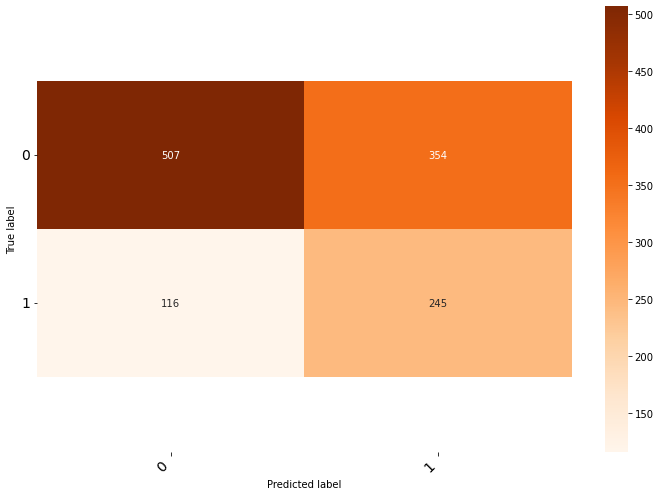

Random Forest Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       861
           1       0.67      0.74      0.70       361

    accuracy                           0.82      1222
   macro avg       0.78      0.79      0.79      1222
weighted avg       0.82      0.82      0.82      1222

accuracy = 0.8166939443535188


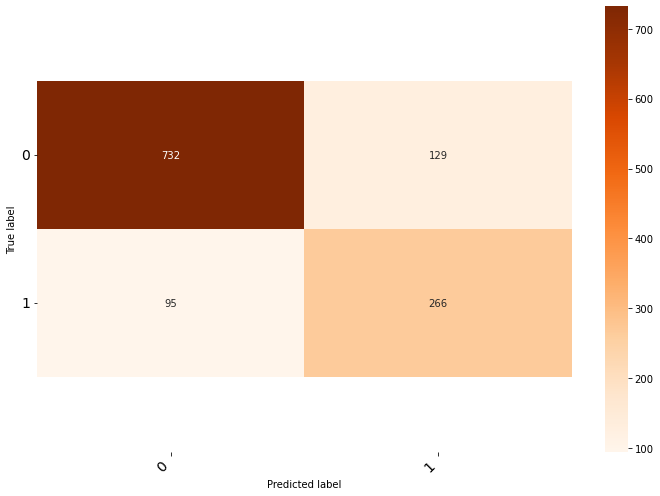

XGB Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       861
           1       0.69      0.77      0.73       361

    accuracy                           0.83      1222
   macro avg       0.80      0.81      0.80      1222
weighted avg       0.84      0.83      0.83      1222

accuracy = 0.8314238952536824


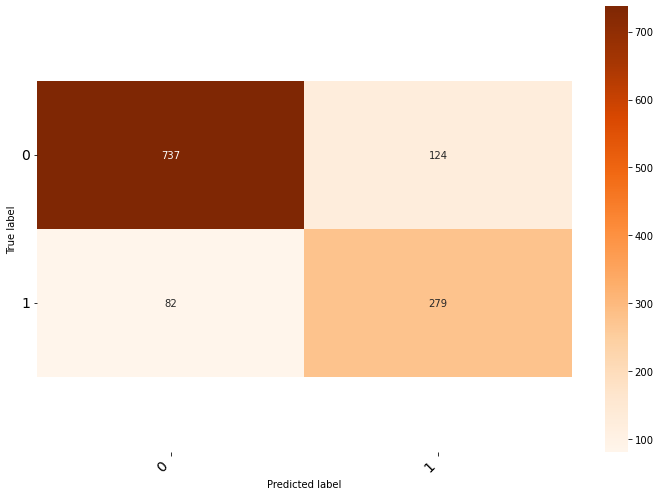

SVM Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.83      0.49      0.62       861
           1       0.39      0.77      0.51       361

    accuracy                           0.57      1222
   macro avg       0.61      0.63      0.57      1222
weighted avg       0.70      0.57      0.59      1222

accuracy = 0.5711947626841244


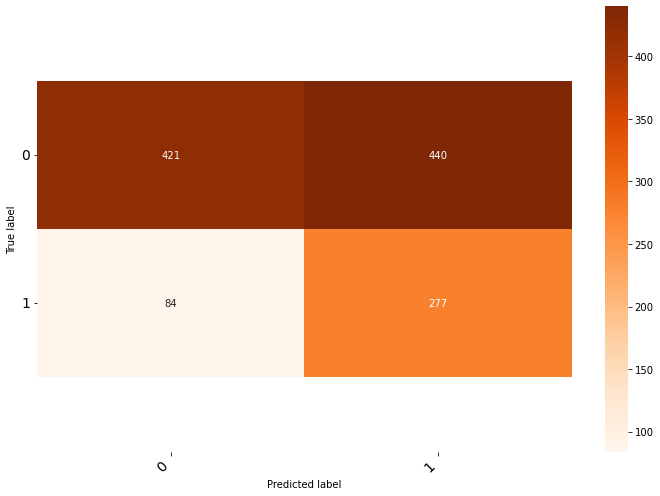

In [29]:
for key in models.keys():
    model(key, inc_train=False)

BUT : Identifier les clients qui quittent la banque du coup la classe qui nous interesse est la classe "1" : classe churn. </br> Pour le choix définitif de notre modèle nous allons regarder principalement la metrique f1-score pour la classe "1" puisqu'elle tient compte de la precision et du recall.</br> Parmi les modèles que nous avons realisé celui qui a le f1-score le plus élévé est "XGBoost" avec f1-score=0.73.</br>

- rappel classe churner = 0.77
- précision classe churner = 0.69
- f1-score classe churner = 0.73

D'autres part , le score du "Random Forest" étant très proche de XGBoost , j'ai décidé donc de choisir ce modèle car , il confirme plus les hypothèses émisent pendant la phase d'analyse descriptive.


No handles with labels found to put in legend.


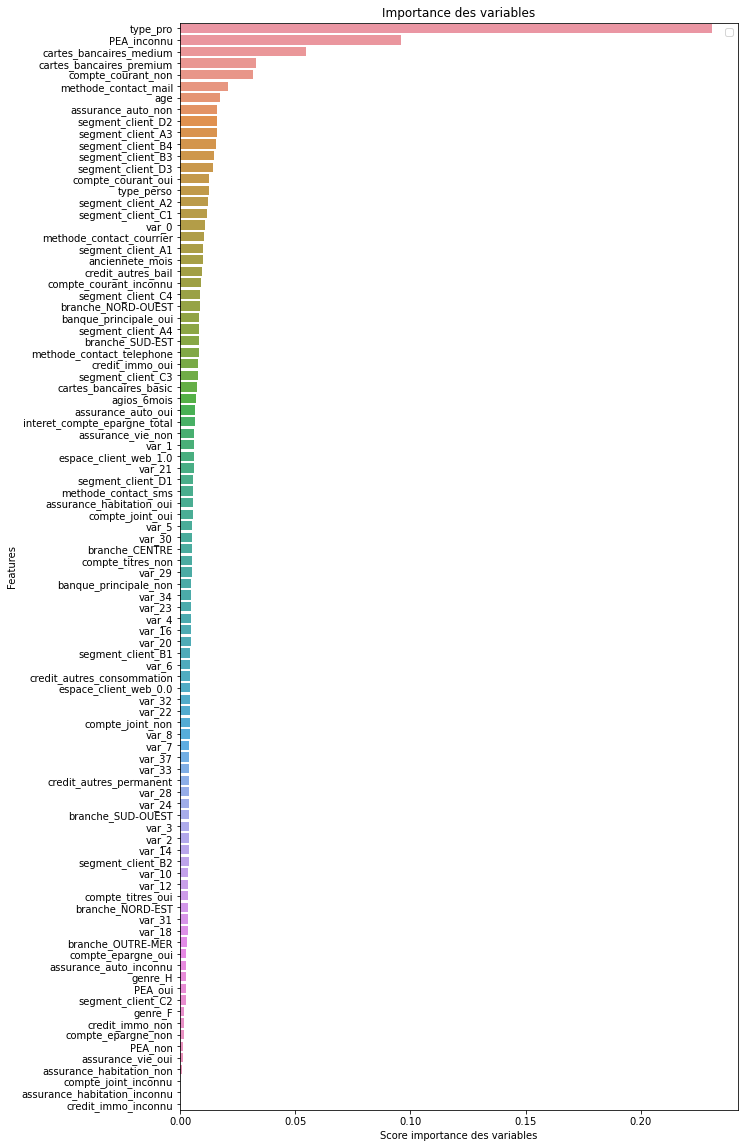

In [30]:
clf_final=xgb.XGBClassifier(**xgb_params)
model = clf_final.fit(X_train, y_train)
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,20))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score importance des variables')
plt.ylabel('Features')
plt.title("Importance des variables")
plt.legend()
plt.savefig(path_images + 'features_importances_xgboost.png')
plt.show()

No handles with labels found to put in legend.


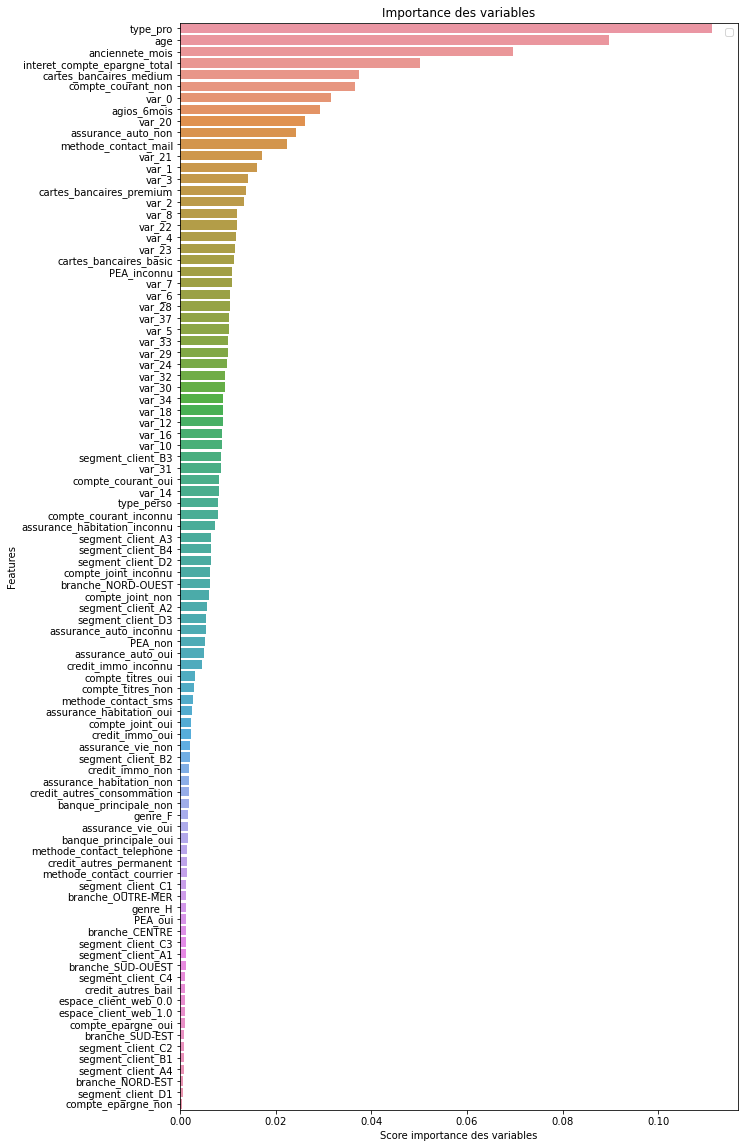

In [31]:
clf_final=RandomForestClassifier(**rf_params)
model = clf_final.fit(X_train, y_train)
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,20))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score importance des variables')
plt.ylabel('Features')
plt.title("Importance des variables")
plt.legend()
plt.savefig(path_images + 'features_importances_random_forest.png')
plt.show()